**Machine Learning Model for dubblin bikes**

In [1]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Allows plots to appear directly in the notebook.
%matplotlib inline

from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 

Merging csv files into one data frame 

In [2]:
stationdf = pd.read_csv('stations.csv')
availability = pd.read_csv('availability.csv')
weather = pd.read_csv('current_weather.csv')

In [3]:
MDF = availability.merge(weather[["weather_desc", "temp", "visibility", "wind_speed", "wind_deg", "timestamp"]], on = ["timestamp"], how = "left")
MDF = MDF.merge(stationdf[["bike_stands", "number"]], on = ["number"], how = "left")
MDF.head()


,number,available_bikes,available_bike_stands,status,last_update,timestamp,weather_desc,temp,visibility,wind_speed,wind_deg,bike_stands
0,42,30,0,OPEN,1677185535000,1677185702,NaN,NaN,NaN,NaN,NaN,30.0
1,30,4,16,OPEN,1677185621000,1677185702,NaN,NaN,NaN,NaN,NaN,20.0
2,54,5,28,OPEN,1677185522000,1677185702,NaN,NaN,NaN,NaN,NaN,33.0
3,108,13,22,OPEN,1677185161000,1677185702,NaN,NaN,NaN,NaN,NaN,35.0
4,20,6,24,OPEN,1677185529000,1677185702,NaN,NaN,NaN,NaN,NaN,30.0


**Cleaning new data frame**

In [4]:
MDF.drop(["status", "last_update"], axis = 1, inplace = True)
MDF.rename(columns = {"bike_stands": "total_stands", "available_bike_stands": "available_stands", "number": "station_num"}, inplace = True)
MDF.head()

,station_num,available_bikes,available_stands,timestamp,weather_desc,temp,visibility,wind_speed,wind_deg,total_stands
0,42,30,0,1677185702,NaN,NaN,NaN,NaN,NaN,30.0
1,30,4,16,1677185702,NaN,NaN,NaN,NaN,NaN,20.0
2,54,5,28,1677185702,NaN,NaN,NaN,NaN,NaN,33.0
3,108,13,22,1677185702,NaN,NaN,NaN,NaN,NaN,35.0
4,20,6,24,1677185702,NaN,NaN,NaN,NaN,NaN,30.0


**Changing time stamps to date and time**

In [5]:
MDF["timestamp"] = pd.to_datetime(MDF["timestamp"], unit = "s")
MDF["month"] = MDF['timestamp'].dt.month  # 1-12
MDF["day"] = MDF['timestamp'].dt.dayofweek  # 0-6
MDF["hour"] = MDF['timestamp'].dt.hour  # 0-23
MDF.drop("timestamp", axis = 1, inplace = True)
MDF.head()

,station_num,available_bikes,available_stands,weather_desc,temp,visibility,wind_speed,wind_deg,total_stands,month,day,hour
0,42,30,0,NaN,NaN,NaN,NaN,NaN,30.0,2,3,20
1,30,4,16,NaN,NaN,NaN,NaN,NaN,20.0,2,3,20
2,54,5,28,NaN,NaN,NaN,NaN,NaN,33.0,2,3,20
3,108,13,22,NaN,NaN,NaN,NaN,NaN,35.0,2,3,20
4,20,6,24,NaN,NaN,NaN,NaN,NaN,30.0,2,3,20


**Reordering columns to match other team formats**

In [7]:
column_order = ["month", "day", "hour", "station_num", "total_stands", "available_stands", "tempC", "weather_desc", "visibility", "wind_speed", "wind_deg", "available_bikes"]
MDF = MDF.reindex(columns = column_order)
MDF.head()

,month,day,hour,station_num,total_stands,available_stands,tempC,weather_desc,visibility,wind_speed,wind_deg,available_bikes
0,2,3,20,42,30.0,0,NaN,NaN,NaN,NaN,NaN,30
1,2,3,20,30,20.0,16,NaN,NaN,NaN,NaN,NaN,4
2,2,3,20,54,33.0,28,NaN,NaN,NaN,NaN,NaN,5
3,2,3,20,108,35.0,22,NaN,NaN,NaN,NaN,NaN,13
4,2,3,20,20,30.0,24,NaN,NaN,NaN,NaN,NaN,6


**Dropping rows with no weather data**

In [8]:
MDF.dropna(inplace = True)
MDF.head()

,month,day,hour,station_num,total_stands,available_stands,tempC,weather_desc,visibility,wind_speed,wind_deg,available_bikes
336580,3,0,14,42,30.0,14,5.66,light rain,10000.0,3.09,290.0,16
336581,3,0,14,30,20.0,20,5.66,light rain,10000.0,3.09,290.0,0
336582,3,0,14,54,33.0,16,5.66,light rain,10000.0,3.09,290.0,17
336583,3,0,14,108,35.0,21,5.66,light rain,10000.0,3.09,290.0,14
336584,3,0,14,20,30.0,8,5.66,light rain,10000.0,3.09,290.0,22


**Replacing weather descriptions with weather IDs**

In [9]:
MDF["weather_desc"] = MDF["weather_desc"].replace({"light rain": 500, "broken clouds": 803, "moderate rain": 501, "light intensity drizzle": 300, "clear sky": 800, "overcast clouds": 804, 
                                                 "scattered clouds": 802, "few clouds": 801, "snow": 601, "heavy intensity rain": 502, "sleet": 611, "mist": 701, "light snow": 600, 
                                                 "light intensity shower rain": 520, "light intensity drizzle rain": 310, "shower rain": 521, "fog": 741})
MDF.head()

,month,day,hour,station_num,total_stands,available_stands,tempC,weather_desc,visibility,wind_speed,wind_deg,available_bikes
336580,3,0,14,42,30.0,14,5.66,500,10000.0,3.09,290.0,16
336581,3,0,14,30,20.0,20,5.66,500,10000.0,3.09,290.0,0
336582,3,0,14,54,33.0,16,5.66,500,10000.0,3.09,290.0,17
336583,3,0,14,108,35.0,21,5.66,500,10000.0,3.09,290.0,14
336584,3,0,14,20,30.0,8,5.66,500,10000.0,3.09,290.0,22


**Changing temperature from Kelvin to Celsius**

In [6]:
MDF["tempC"] = MDF["temp"]-273.15
MDF.drop('temp', axis = 1, inplace = True)

**Data separation**

**Y variable data**

In [10]:
y = MDF["available_bikes"]
y

336580     16
336581      0
336582     17
336583     14
336584     22
           ..
1281561     7
1281562     0
1281563     0
1281564    16
1281565    11
Name: available_bikes, Length: 787740, dtype: int64

**X variable**

In [11]:
x = MDF.drop("available_bikes", axis = 1)
x 

,month,day,hour,station_num,total_stands,available_stands,tempC,weather_desc,visibility,wind_speed,wind_deg
336580,3,0,14,42,30.0,14,5.66,500,10000.0,3.09,290.0
336581,3,0,14,30,20.0,20,5.66,500,10000.0,3.09,290.0
336582,3,0,14,54,33.0,16,5.66,500,10000.0,3.09,290.0
336583,3,0,14,108,35.0,21,5.66,500,10000.0,3.09,290.0
336584,3,0,14,20,30.0,8,5.66,500,10000.0,3.09,290.0
...,...,...,...,...,...,...,...,...,...,...,...
1281561,4,1,8,39,20.0,13,8.85,803,10000.0,3.09,160.0
1281562,4,1,8,83,40.0,40,8.85,803,10000.0,3.09,160.0
1281563,4,1,8,92,40.0,40,8.85,803,10000.0,3.09,160.0
1281564,4,1,8,21,30.0,14,8.85,803,10000.0,3.09,160.0


**Creating data sets**

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)

**Model Building**

**Training Model**

In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

**Implementing the model**

In [14]:
y_lr_train_pred = lr.predict(x_train)
y_lr_test_pred = lr.predict(x_test)

print(y_lr_train_pred[:100])

[ 0.71176789  1.65821602 25.27927443 10.34408724  0.75660027 12.47505307
 27.69754294 37.89680168 17.80751586 15.96859882  5.13459385  7.83794881
  7.86638828  4.56053744 27.14496372 14.98437126 19.18017325  6.94492044
  7.74065055 10.66147116 15.56664632 16.48504561 20.62627469  9.69803079
 25.15085317  9.37853359 12.93506156 17.35865515 29.98199599 12.23237792
  1.13566416 23.35626532 15.5279953   7.44949089 11.61738455 18.34318049
 17.75678555 28.65560675  0.77572027  5.38709058  0.48312809 37.5538287
 17.6467782   4.2337042  15.79835346 23.20041236  6.70391554  1.39720347
 36.05152564  6.73606146  0.28609358  6.58257899  4.33444905 -0.36413118
 28.32331065  8.74609839  7.90959605 -0.15046401  5.6370166  14.56266207
  7.61184177  6.38335169 10.2479457  14.57371562 -0.24202546 14.05948762
 16.15100904 31.41333758 13.6856073   2.39455909 17.94401493 14.81917914
  7.9540161   4.35002816 16.58881666 14.98548628 19.54986334 21.16715384
 14.81293239 14.24398265 12.74479222  8.23233371  3.

In [15]:
print(y_lr_test_pred[:100])

[12.7990898  24.2096296   2.0595962  36.49117772  5.33264481 18.98676247
  5.47703191  0.07300997 -0.3230541   9.85046661 11.64467353  6.58515576
  2.03875958  1.42926005  9.12923416 23.53792474 13.95400005  1.21064871
  4.87210434 14.88595699  8.79177575  1.80550372  3.54280055  3.28871525
  6.4686931  12.67848499  5.6737148  10.96592111 18.59223746 21.08371424
  1.7779735   5.65353366 23.38299727  2.3353746   2.26417777  8.04333367
  8.76564513 12.29128602  4.33893106 18.73120654 10.36704703 26.81464926
 13.94492457  3.99745715  0.32894622 21.72923114 17.51998545  9.27889466
  0.15698212  8.45511087  3.04708344 18.7959866   8.89785413 13.27106883
  9.9606046   5.54743785 10.64508123 18.12896787  3.00890449 10.17926588
 17.39696802  2.04860337 12.51193237 12.03682292  8.47065061  0.20757855
 12.51917274 26.27426886  5.59005726  7.50804166 14.68627874  4.10764869
 12.37764216  5.37723248 29.68600678  3.5061512   2.45717179 21.31578954
  9.89536929  9.48074849 26.85302936  3.94166858  6

**Model Performance**

In [16]:
from sklearn.metrics import mean_squared_error, r2_score

lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)

lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

In [17]:
lr_results = pd.DataFrame(["Linear regression", lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
lr_results.columns = ["Method", "Training MSE", "Training R2", "Test MSE", "Test R2"]
lr_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,5.650267,0.936988,5.552693,0.937708


**Decision tree model**

In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)


In [19]:
dt = DecisionTreeRegressor()
dt.fit(x_test, y_test)

DecisionTreeRegressor()

In [20]:
y_dt_train_pred = dt.predict(x_train)
y_dt_test_pred = dt.predict(x_test)
print(y_dt_train_pred[:100])

[ 1.  2. 26. 10.  1. 13. 29. 39. 19. 16.  5.  6.  8.  5. 27. 15. 20.  7.
  8. 11. 16. 15. 21. 10. 26. 10.  0. 18. 31. 13.  1. 24. 16.  8. 12. 19.
 19. 30.  1.  3.  0. 38. 18.  4. 17. 24.  7.  1. 37.  7.  0.  7.  2.  0.
 30.  9.  8.  0.  6. 15.  8.  6. 10. 15.  0. 15. 15. 32. 14.  3. 19. 15.
  8.  5. 17. 16. 20. 22.  2. 15. 13.  9.  4.  9.  6. 17.  5.  1.  0. 12.
  5. 11.  0.  5. 19.  1.  0. 21. 14.  2.]


In [21]:
print(y_dt_test_pred[:100])

[ 0. 25.  2. 38.  6. 20.  6.  0.  0. 10. 12.  7.  2.  1. 10. 24. 14.  1.
  5. 16.  9.  2.  4.  3.  7. 13.  6. 11. 19. 22.  2.  6. 24.  0.  2.  8.
  9. 13.  4. 19. 11. 27. 14.  4.  0. 23. 18.  9.  0.  9.  3. 19.  9. 14.
 10.  6. 11. 19.  3. 11. 17.  2. 13. 13.  9.  0. 13. 27.  6.  8. 15.  4.
 13.  6. 31.  3.  2. 22. 10. 10. 28.  4.  7. 10. 14.  9. 16.  3.  0.  1.
 19.  8.  2. 36.  4.  9.  1. 18. 23. 16.]


In [22]:

dt_test_mse = mean_squared_error(y_test, y_dt_test_pred)
dt_test_r2 = r2_score(y_test, y_dt_test_pred)
dt_train_mse = mean_squared_error(y_train, y_dt_train_pred)
dt_train_r2 = r2_score(y_train, y_dt_train_pred)

In [23]:
dt_results = pd.DataFrame(["Decision tree", dt_train_mse, dt_train_r2, dt_test_mse, dt_test_r2]).transpose()
dt_results.columns = ["Method", "Training MSE", "Training R2", "Test MSE", "Test R2"]
dt_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Decision tree,0.330528,0.996314,0.000077,0.999999


**Random forest model**

In [24]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=2, random_state=100)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=2, random_state=100)

In [25]:
y_rf_train_pred = rf.predict(x_train)
y_rf_test_pred = rf.predict(x_test)
print(y_rf_train_pred[:100])

[10.48678732 10.48678732 25.38123754  4.44165625  4.44165625 10.48678732
 25.38123754 25.38123754 25.38123754 10.48678732  4.44165625  4.44165625
 10.48678732 10.63172039 25.38123754 10.48678732 11.08236479  4.44165625
 10.48678732 10.48678732 25.38123754 25.38123754 10.48678732 10.48678732
 25.38123754 10.48678732 11.08236479 25.38123754 25.38123754 11.08236479
  4.44165625 10.48678732 25.38123754 11.08236479 10.48678732 25.38123754
 11.08236479 25.38123754 10.48678732 11.08236479  4.44165625 25.38123754
 10.48678732  4.44165625 11.08236479 25.38123754 10.48678732  4.44165625
 25.38123754 10.48678732  4.44165625 10.48678732 11.08236479 10.48678732
 25.38123754 10.48678732  4.44165625 10.48678732 10.48678732 15.02184121
 11.08236479  4.44165625  4.44165625 10.48678732 10.48678732 11.08236479
 11.08236479 25.38123754 10.48678732 10.48678732 11.08236479 10.48678732
  4.44165625 10.63172039 25.38123754 11.08236479 10.48678732 25.38123754
 11.08236479 15.02184121  4.44165625 11.08236479 10

In [26]:
print(y_rf_test_pred[:100])

[11.08236479 15.02184121  4.44165625 25.38123754 10.63172039 25.38123754
 10.48678732 10.48678732  4.44165625  4.44165625  4.44165625 11.08236479
 10.48678732  4.44165625 11.08236479 10.48678732 10.48678732  4.44165625
 10.48678732 11.08236479 10.48678732 10.48678732 10.48678732  4.44165625
 10.48678732 10.48678732 10.48678732  4.44165625 10.48678732 25.38123754
 10.48678732 10.48678732 10.48678732  4.44165625  4.44165625  4.44165625
 10.48678732 11.08236479 10.48678732 10.48678732 10.48678732 25.38123754
 10.48678732 10.48678732  4.44165625 25.38123754 25.38123754  4.44165625
  4.44165625 11.08236479  4.44165625 10.48678732  4.44165625 11.08236479
 10.48678732 10.48678732 10.48678732 25.38123754  4.44165625 10.48678732
 10.48678732  4.44165625 10.48678732 11.08236479 11.08236479  4.44165625
 10.48678732 25.38123754 11.08236479 10.63172039 10.48678732 10.48678732
 11.08236479 11.08236479 25.38123754  4.44165625  4.44165625 10.48678732
  4.44165625 10.48678732 25.38123754 10.48678732  4

In [27]:
from sklearn.metrics import mean_squared_error, r2_score

rf_train_mse = mean_squared_error(y_train, y_rf_train_pred)
rf_train_r2 = r2_score(y_train, y_rf_train_pred)

rf_test_mse = mean_squared_error(y_test, y_rf_test_pred)
rf_test_r2 = r2_score(y_test, y_rf_test_pred)

In [28]:
rf_results = pd.DataFrame(["Random forest", rf_train_mse, rf_train_r2, rf_test_mse, rf_test_r2]).transpose()
rf_results.columns = ["Method", "Training MSE", "Training R2", "Test MSE", "Test R2"]
rf_results

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Random forest,34.764468,0.612304,34.672684,0.611033


**Model comparison**

In [29]:
df_models = pd.concat([lr_results, dt_results, rf_results], axis=0).reset_index(drop=True)
df_models

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,5.650267,0.936988,5.552693,0.937708
1,Decision tree,0.330528,0.996314,0.000077,0.999999
2,Random forest,34.764468,0.612304,34.672684,0.611033


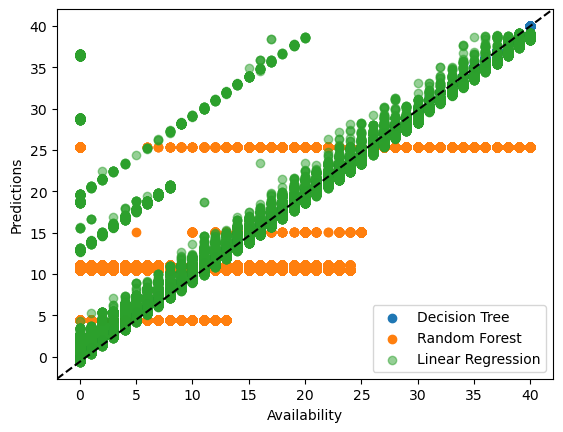

In [35]:
import matplotlib.pyplot as plt

# make predictions for each model on the testing data
y_pred_dt = dt.predict(x_test)
y_pred_rf = rf.predict(x_test)
y_pred_lr = lr.predict(x_test)

# plot the predicted values against the true values for each model
plt.scatter(y_test, y_pred_dt, label="Decision Tree")
plt.scatter(y_test, y_pred_rf, label="Random Forest")
plt.scatter(y_test, y_pred_lr, label="Linear Regression", alpha = 0.5)

# add a diagonal line to represent perfect predictions
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)

plt.xlabel("Availability")
plt.ylabel("Predictions")
plt.legend()

plt.show()


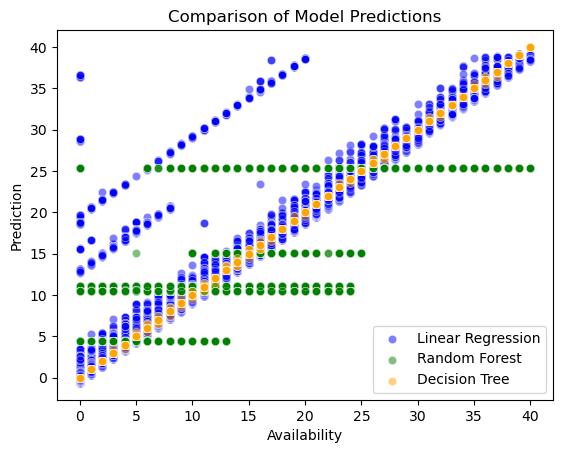

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

model_names = ['Linear Regression', 'Random Forest', 'Decision Tree']
models = [lr, rf, dt]
colors = ['blue', 'green', 'orange']

for i, model in enumerate(models):
    sns.scatterplot(x=y_test, y=model.predict(x_test), color=colors[i], alpha=0.5)

plt.title('Comparison of Model Predictions')
plt.xlabel('Availability')
plt.ylabel('Prediction')
plt.legend(model_names)
plt.show()
